In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

In [3]:
import vice

from surp import subgiants
from surp import gce_math as gcem
from surp.gce_math import MH_to_Z, Z_to_MH, Z_SUN
import surp

import arya

/users/PAS2232/aeyobd/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [4]:
from scipy.stats import t, norm


In [5]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [6]:
surp.set_yields()

In [7]:
all_abundances = pd.read_csv("data_analysis/all_data.csv")
stars = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
stars["MG_H"] =  stars["[O/H]3N"]
stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances["C_MG"] = all_abundances["[c/o]"]
all_abundances["MG_H"] = all_abundances["[o/h]"]
all_abundances["C_MG_ERR"] = all_abundances["[c/o]_err"]

stars_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "star")]
RL_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "RL")]
DLA_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "DLA")]
dwarf_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "dwarf")]

In [8]:
stars_x_obs = stars.MG_H
stars_y_obs = stars.C_MG
all_x_obs = all_abundances.MG_H
all_y_obs = all_abundances.C_MG

In [9]:

filt = ~subgiants.high_alpha.values
df = subgiants[filt]

bins = np.quantile(df.MG_H, np.linspace(0, 1, 20))

counts = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic='count')[0]

ym = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic='median')[0]
yl = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic=lambda x: np.percentile(x, 16))[0]
yh = binned_statistic(df.MG_H, df.C_MG, bins=bins, statistic=lambda x: np.percentile(x, 84))[0]
ym_err = binned_statistic(df.MG_H, df.C_MG_ERR, bins=bins, statistic='mean')[0]


xm = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic='median')[0]
xl = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic=lambda x: np.percentile(x, 16))[0]
xh = binned_statistic(df.MG_H, df.MG_H, bins=bins, statistic=lambda x: np.percentile(x, 84))[0]
xm_err = binned_statistic(df.MG_H, df.MG_H_ERR, bins=bins, statistic='mean')[0]

In [10]:
yym = gcem.brak_to_abund(ym, "c", "mg")
yyl = gcem.brak_to_abund(yl - ym_err, "c", "mg")
yyh = gcem.brak_to_abund(yh + ym_err, "c", "mg")
yym_err = (yyh - yyl) / 2 / np.sqrt(counts)

x_err = (xh - xl)/ 2 / np.sqrt(counts)

In [11]:
obs = (xm, yym, x_err, yym_err)

In [12]:
def plot_obs():
    plt.errorbar(xm, yym, yerr=yym_err, xerr=x_err,  fmt=".", capsize=0)

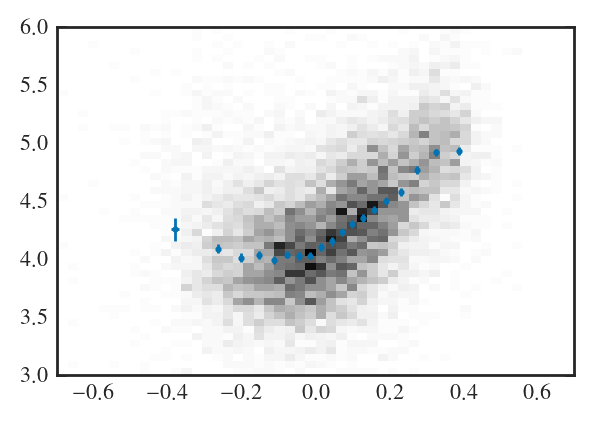

In [13]:
plt.hist2d(df.MG_H, gcem.brak_to_abund(df.C_MG, "c", "mg"), 50, range=([-0.7, 0.7], [3, 6]), cmap="Greys")
plot_obs()


In [14]:
import sys
sys.path.append("../models")

In [21]:
from make_yields import y_c_lin, Y_C_Q, A_C_Q, B_C_Q, y_c_quad

In [22]:
ymg = vice.yields.ccsne.settings["mg"]

In [23]:
y_c_2 = surp.yield_models.Quadratic_CC(y0=Y_C_Q, A=A_C_Q, B=B_C_Q)

In [24]:
ymg

0.000652

In [25]:
surp.set_yields()

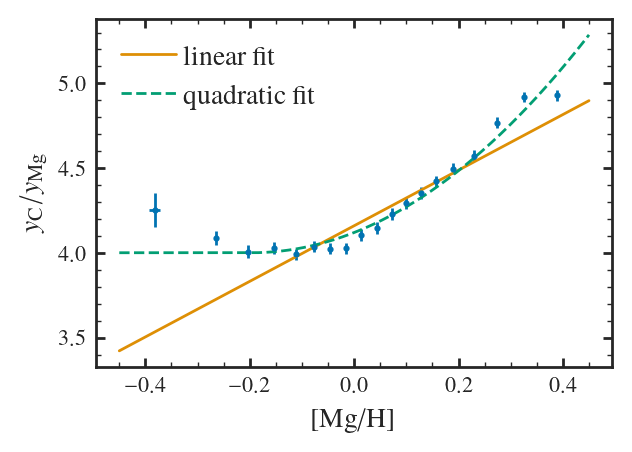

In [28]:
plot_obs()
x = np.linspace(-0.45, 0.45, 1000)
plt.plot(x, y_c_lin(x) / ymg, label="linear fit")
plt.plot(x, [y_c_2(gcem.MH_to_Z(xx))/ymg for xx in x], ls="--", label="quadratic fit")

plt.legend()
plt.xlabel("[Mg/H]")
plt.ylabel(r"$y_{\rm C} / y_{\rm Mg}$")
plt.savefig("figures/equilibrium_yield.pdf")

# LS Fits

In [14]:
from scipy.optimize import curve_fit

In [15]:
def loglin(x, a, b):
    return a + b*x

In [16]:
popt, covt = curve_fit(loglin, xm, yym, sigma=yym_err)

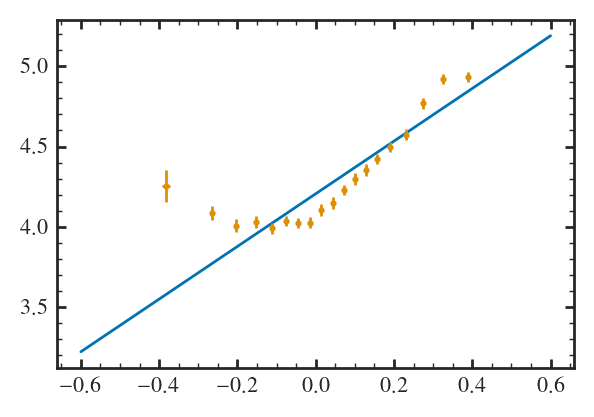

In [17]:
x_pred = np.linspace(-0.6, 0.6, 1000)
y_pred = loglin(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

In [18]:
def lin(x, a, b):
    Z = gcem.MH_to_Z(x)
    return a + b*(Z - Z_SUN)

In [19]:
popt, covt = curve_fit(lin, xm, yym, sigma=yym_err)

In [20]:
popt

array([ 4.15787404, 36.59623537])

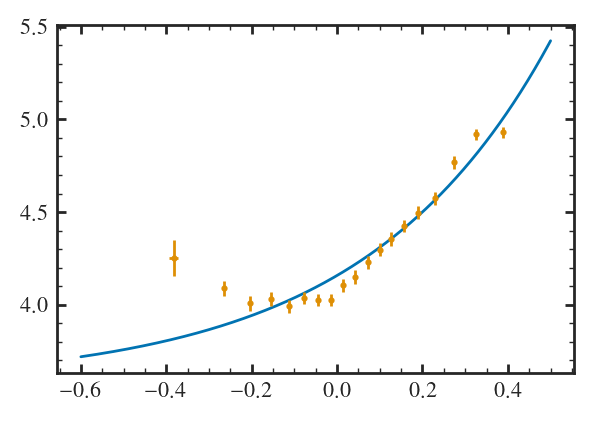

In [21]:
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = lin(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

In [22]:
def logquad(x, a, b, c):
    return a + b*x + c*x**2

In [23]:
popt, covt = curve_fit(logquad, xm, yym, sigma=yym_err)

In [24]:
popt

array([4.12000938, 1.19517306, 3.16358275])

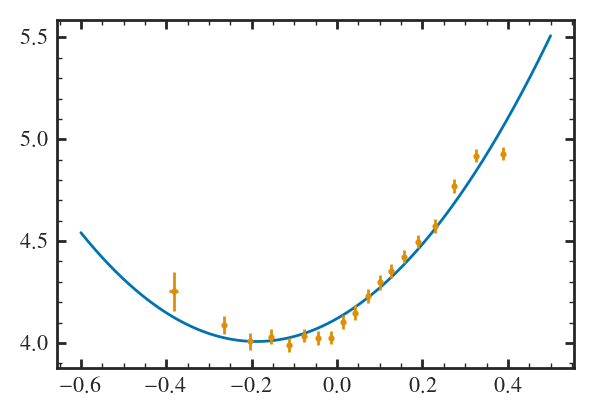

In [25]:
x_pred = np.linspace(-0.6, 0.5, 1000)
y_pred = logquad(x_pred, *popt)
plt.plot(x_pred, y_pred)
plot_obs()

# How do the stars work?

In [26]:
ymg = vice.yields.ccsne.settings["mg"]

In [33]:
def agb_model(m_h):
    return (3.23e-04 + -4.79e-04*m_h - 0*6.43e-05*m_h**2) / ymg

In [34]:
x_pred = np.linspace(-2, 0.6, 1000)
y_pred = logquad(x_pred, *popt)

(-2.5, 0.6)

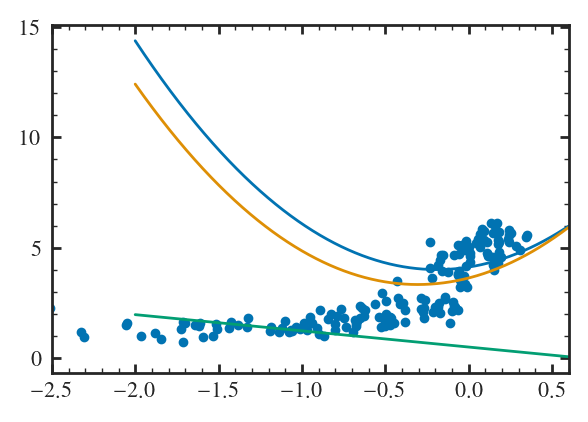

In [35]:
plt.scatter(stars_x_obs, gcem.brak_to_abund(stars_y_obs, "c", "mg"))
plt.plot(x_pred, y_pred)
plt.plot(x_pred, y_pred - agb_model(x_pred))
plt.plot(x_pred, agb_model(x_pred))

plt.xlim(-2.5, 0.6)

# MCMC fits

In [41]:
N = 3_000

In [37]:
import mcmc_utils

In [38]:
def plot_res(model, samples):
    theta_m = np.median(samples, axis=0)
    y_pred = model(xm, theta_m)

    #plt.scatter(x_obs, y_obs - y_pred, s=2, c=w, ec="none", cmap="Greys", alpha=0.4)
    plt.scatter(xm, yym - y_pred, )
    plt.ylim(-0.3, 0.3)
    plt.xlim(-0.5)
    plt.axhline(0, ls="--")

In [39]:
model = mcmc_utils.Linear(beta0=[4, 0.5], beta1=[0, 1], log_sigma=[-15, 0.5])

100%|██████████| 1000/1000 [00:11<00:00, 90.61it/s]


$\beta_0$ = 4.02e+00 + 5.24e-01 - 5.33e-01
$\beta_1$ = 3.25e-02 + 1.02e+00 - 1.10e+00
$\log(\sigma)$ = -1.51e+01 + 4.85e-01 - 5.58e-01


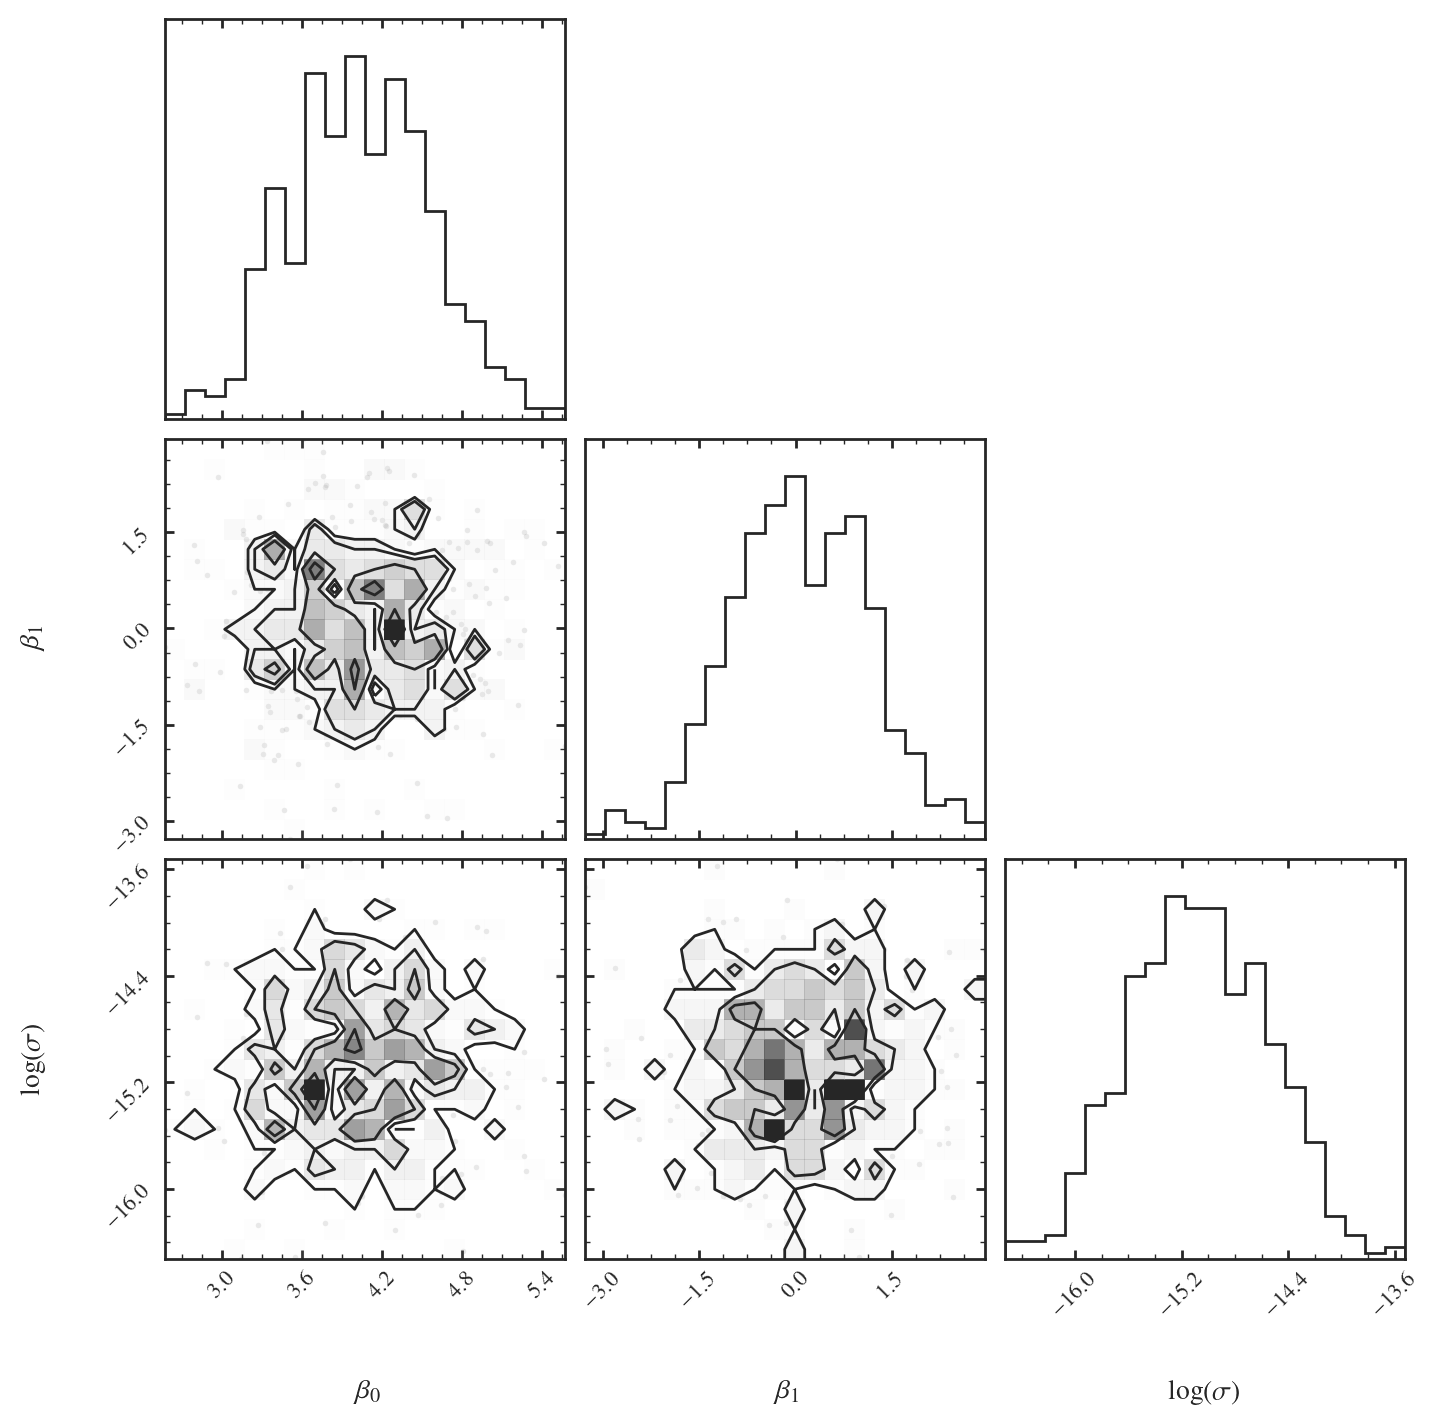

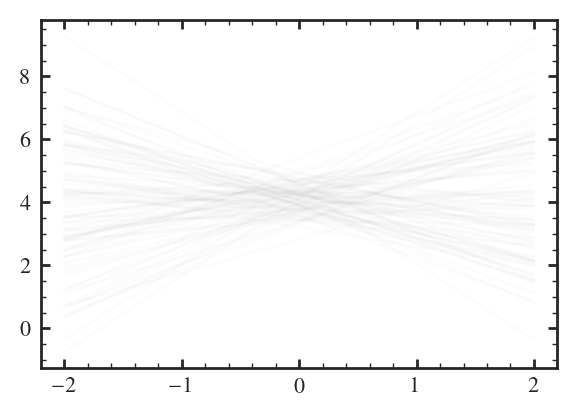

In [40]:
mcmc_utils.plot_prior(model, N=1_000)

100%|██████████| 3000/3000 [00:32<00:00, 91.54it/s]


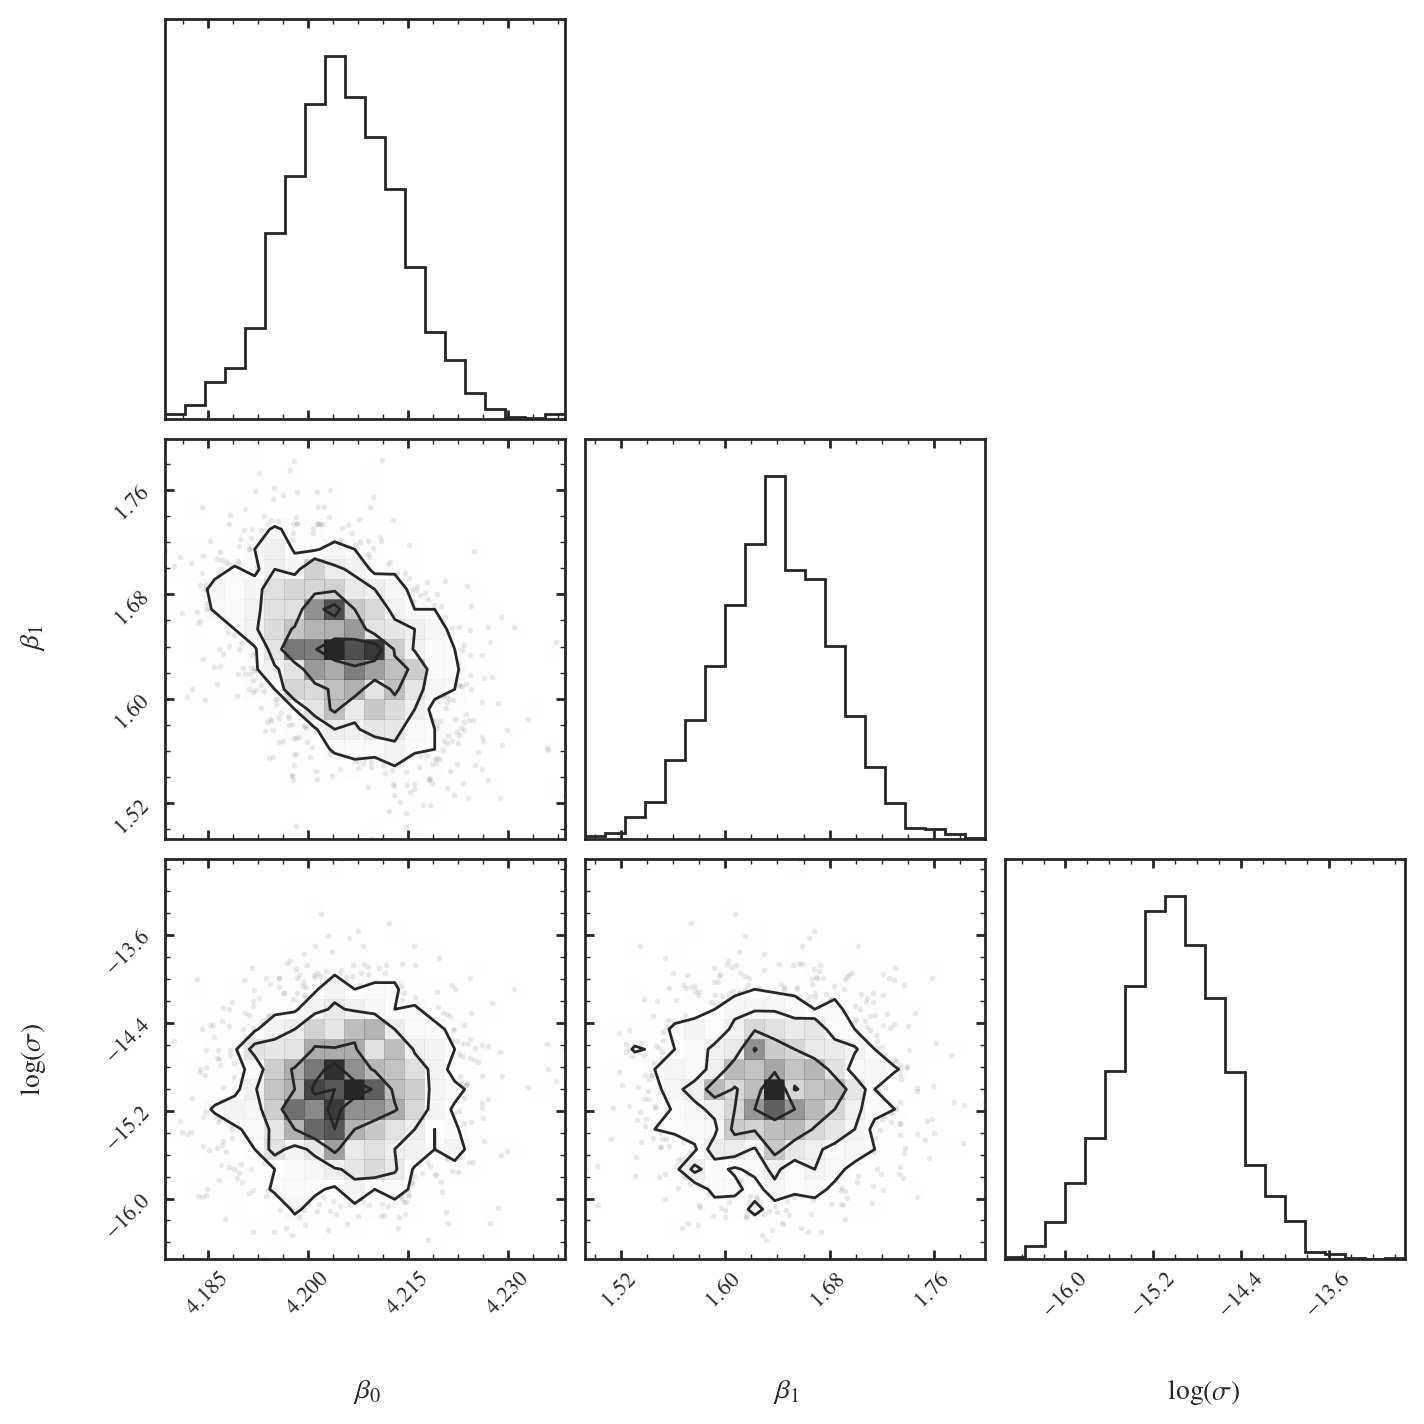

In [42]:
samples = mcmc_utils.run_mcmc(model, obs,N=N )

$\beta_0$ = 4.20e+00 + 8.20e-03 - 8.82e-03
$\beta_1$ = 1.64e+00 + 4.43e-02 - 4.43e-02
$\log(\sigma)$ = -1.50e+01 + 4.72e-01 - 4.97e-01


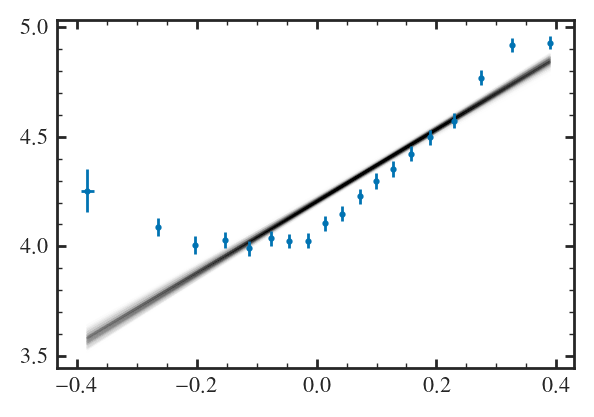

In [43]:
mcmc_utils.plot_posterior(model, obs, samples, N_lines=500)

# Exponential model

In [56]:
model  = mcmc_utils.Exponential(beta0=[4, 0.5], beta1=[0, 1], log_sigma=[-15, 1])

100%|██████████| 1000/1000 [00:10<00:00, 95.64it/s]


$\beta_0$ = 3.99e+00 + 4.94e-01 - 5.17e-01
$\beta_1$ = 7.73e-02 + 1.12e+00 - 1.01e+00
$\log(\sigma)$ = -1.50e+01 + 8.99e-01 - 1.00e+00


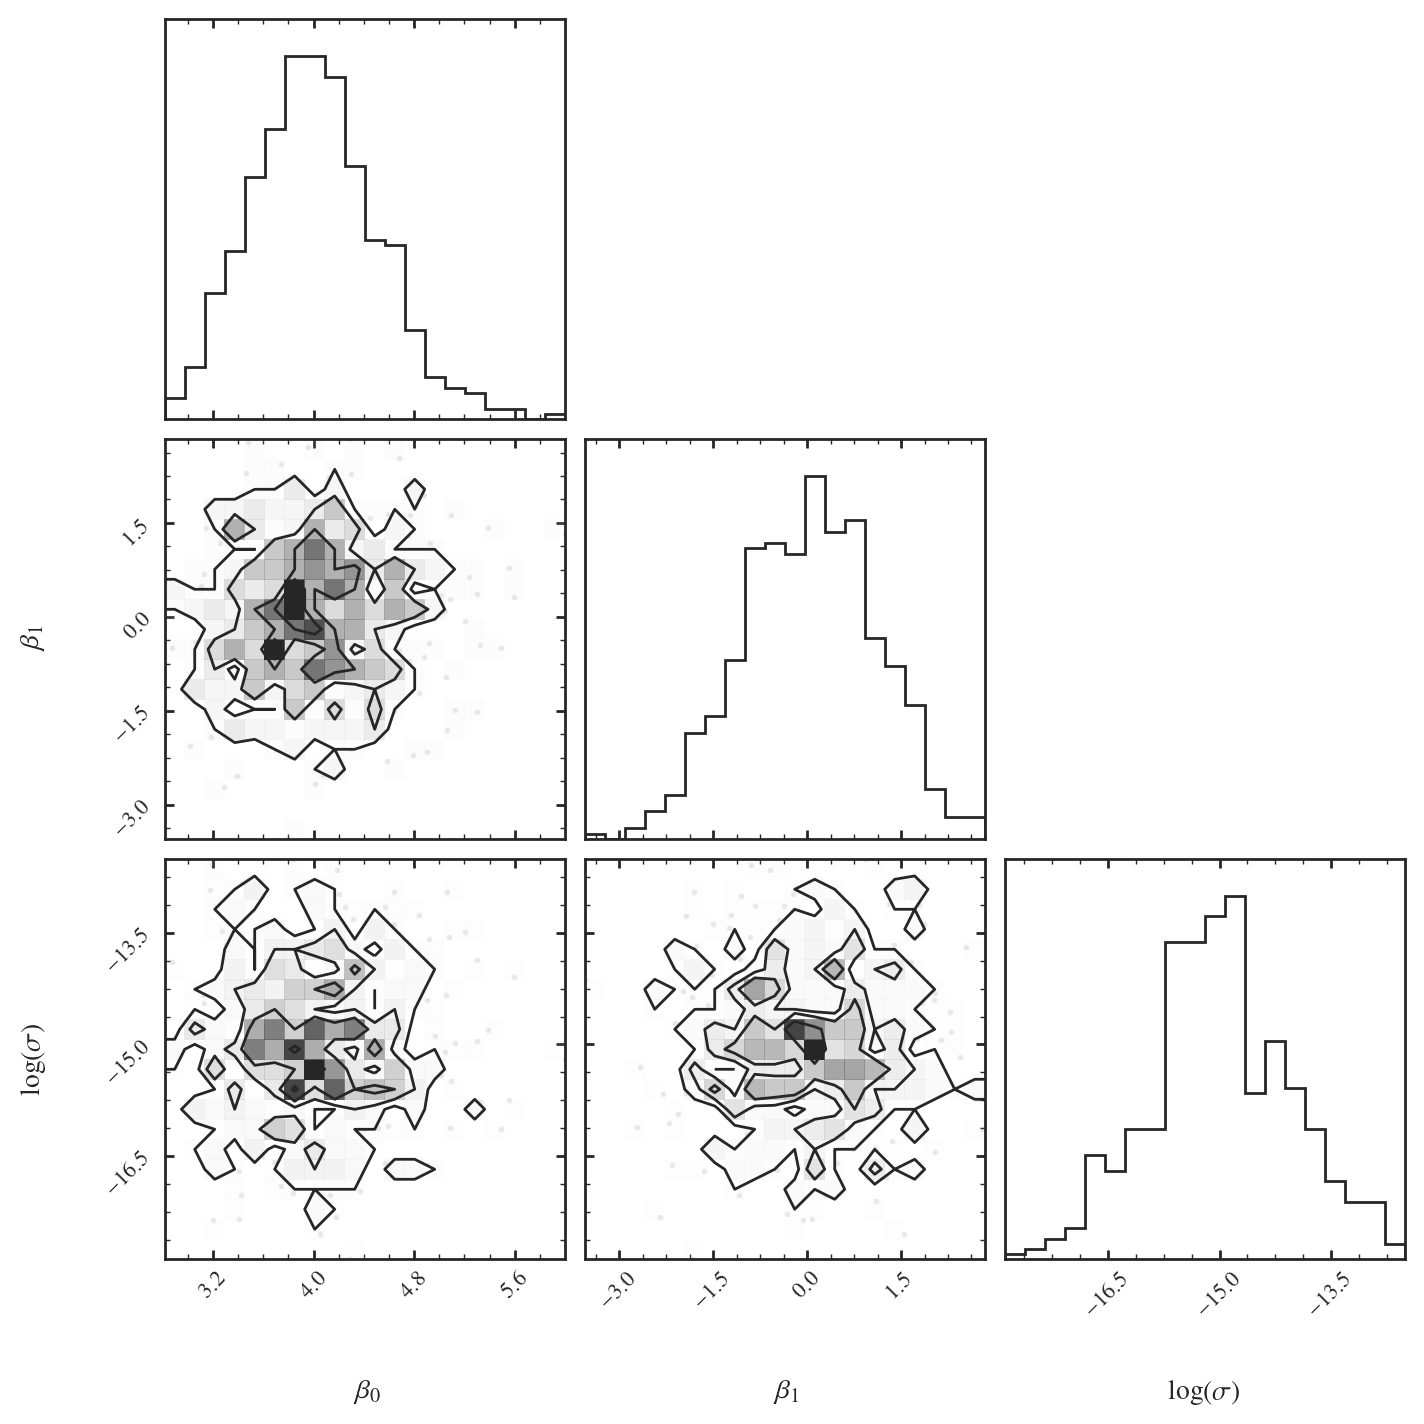

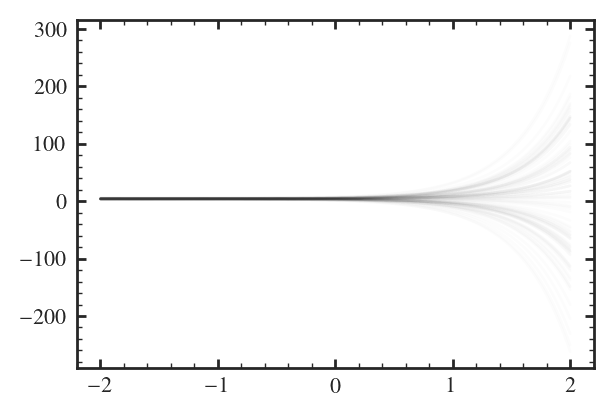

In [57]:
mcmc_utils.plot_prior(model)

100%|██████████| 3000/3000 [00:34<00:00, 86.22it/s]


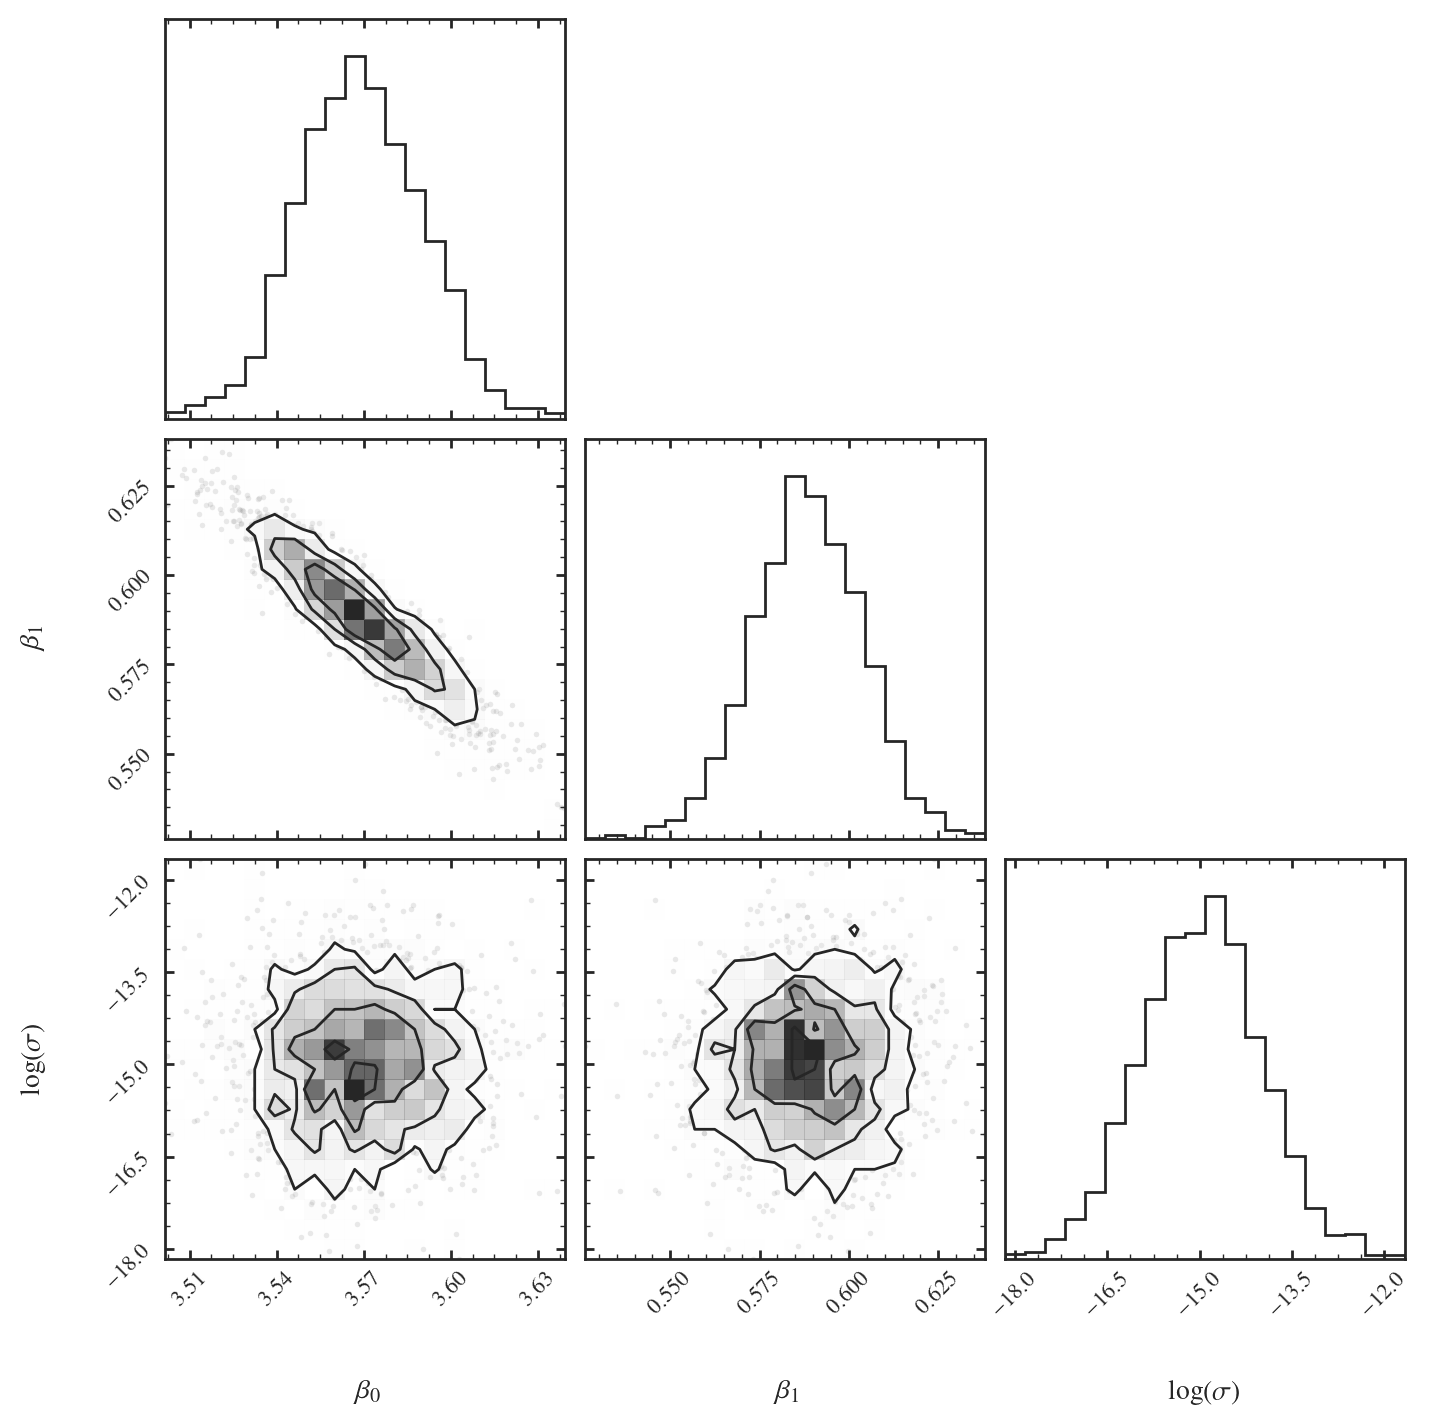

In [58]:
samples = mcmc_utils.run_mcmc(model, obs, N=N)

$\beta_0$ = 3.57e+00 + 2.03e-02 - 2.23e-02
$\beta_1$ = 5.88e-01 + 1.55e-02 - 1.52e-02
$\log(\sigma)$ = -1.50e+01 + 9.88e-01 - 9.53e-01


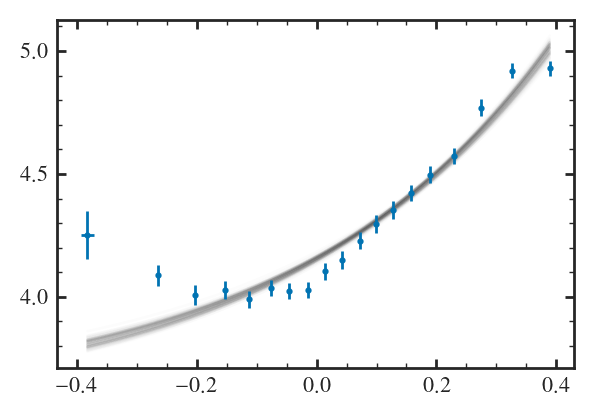

In [59]:
mcmc_utils.plot_posterior(model, obs, samples)

## Quadratic model

In [60]:
model  = mcmc_utils.Quadratic(beta0=[4, 0.5], beta1=[0, 1], log_sigma=[-15, 1])

100%|██████████| 1000/1000 [00:11<00:00, 89.68it/s]


$\beta_0$ = 3.86e+00 + 3.94e-01 - 5.11e-01
$\beta_1$ = -5.06e-02 + 1.02e+00 - 1.02e+00
$\beta_2$ = -5.71e-02 + 1.04e+00 - 1.04e+00
$\log(\sigma)$ = -1.50e+01 + 1.04e+00 - 1.02e+00


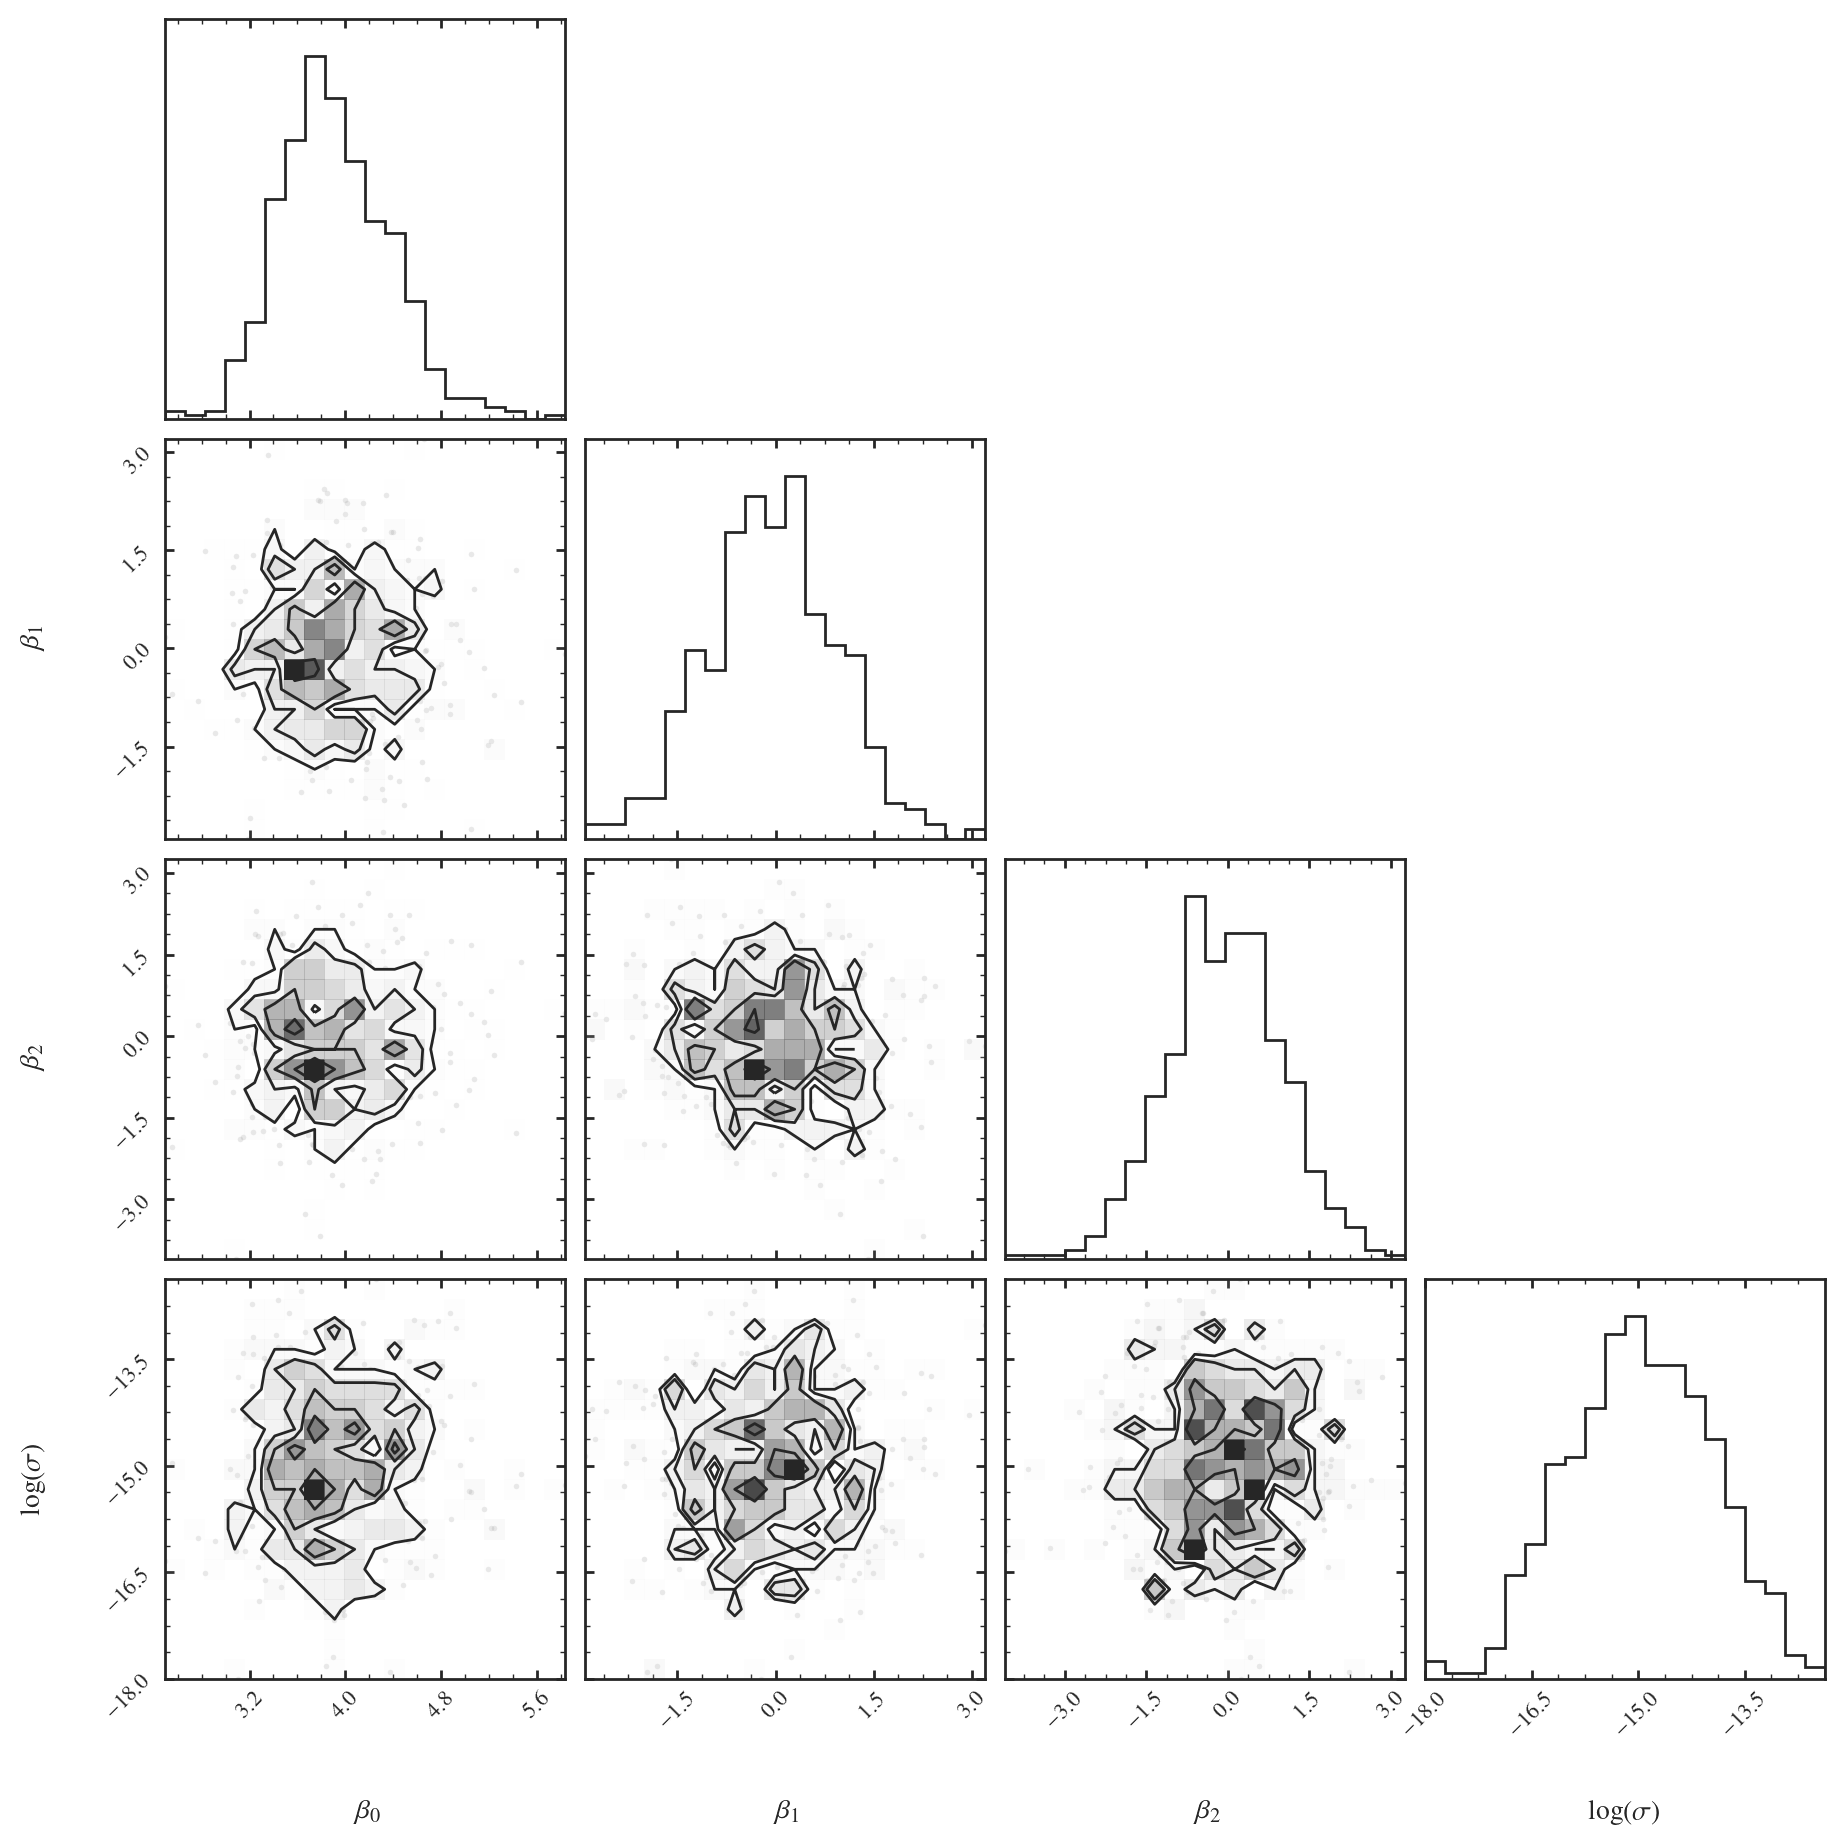

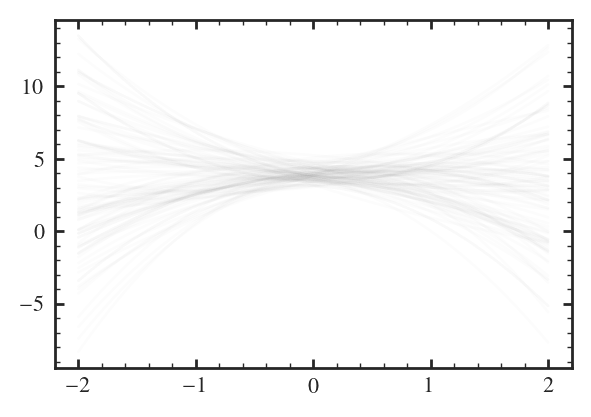

In [61]:
mcmc_utils.plot_prior(model)

100%|██████████| 3000/3000 [00:35<00:00, 83.74it/s]


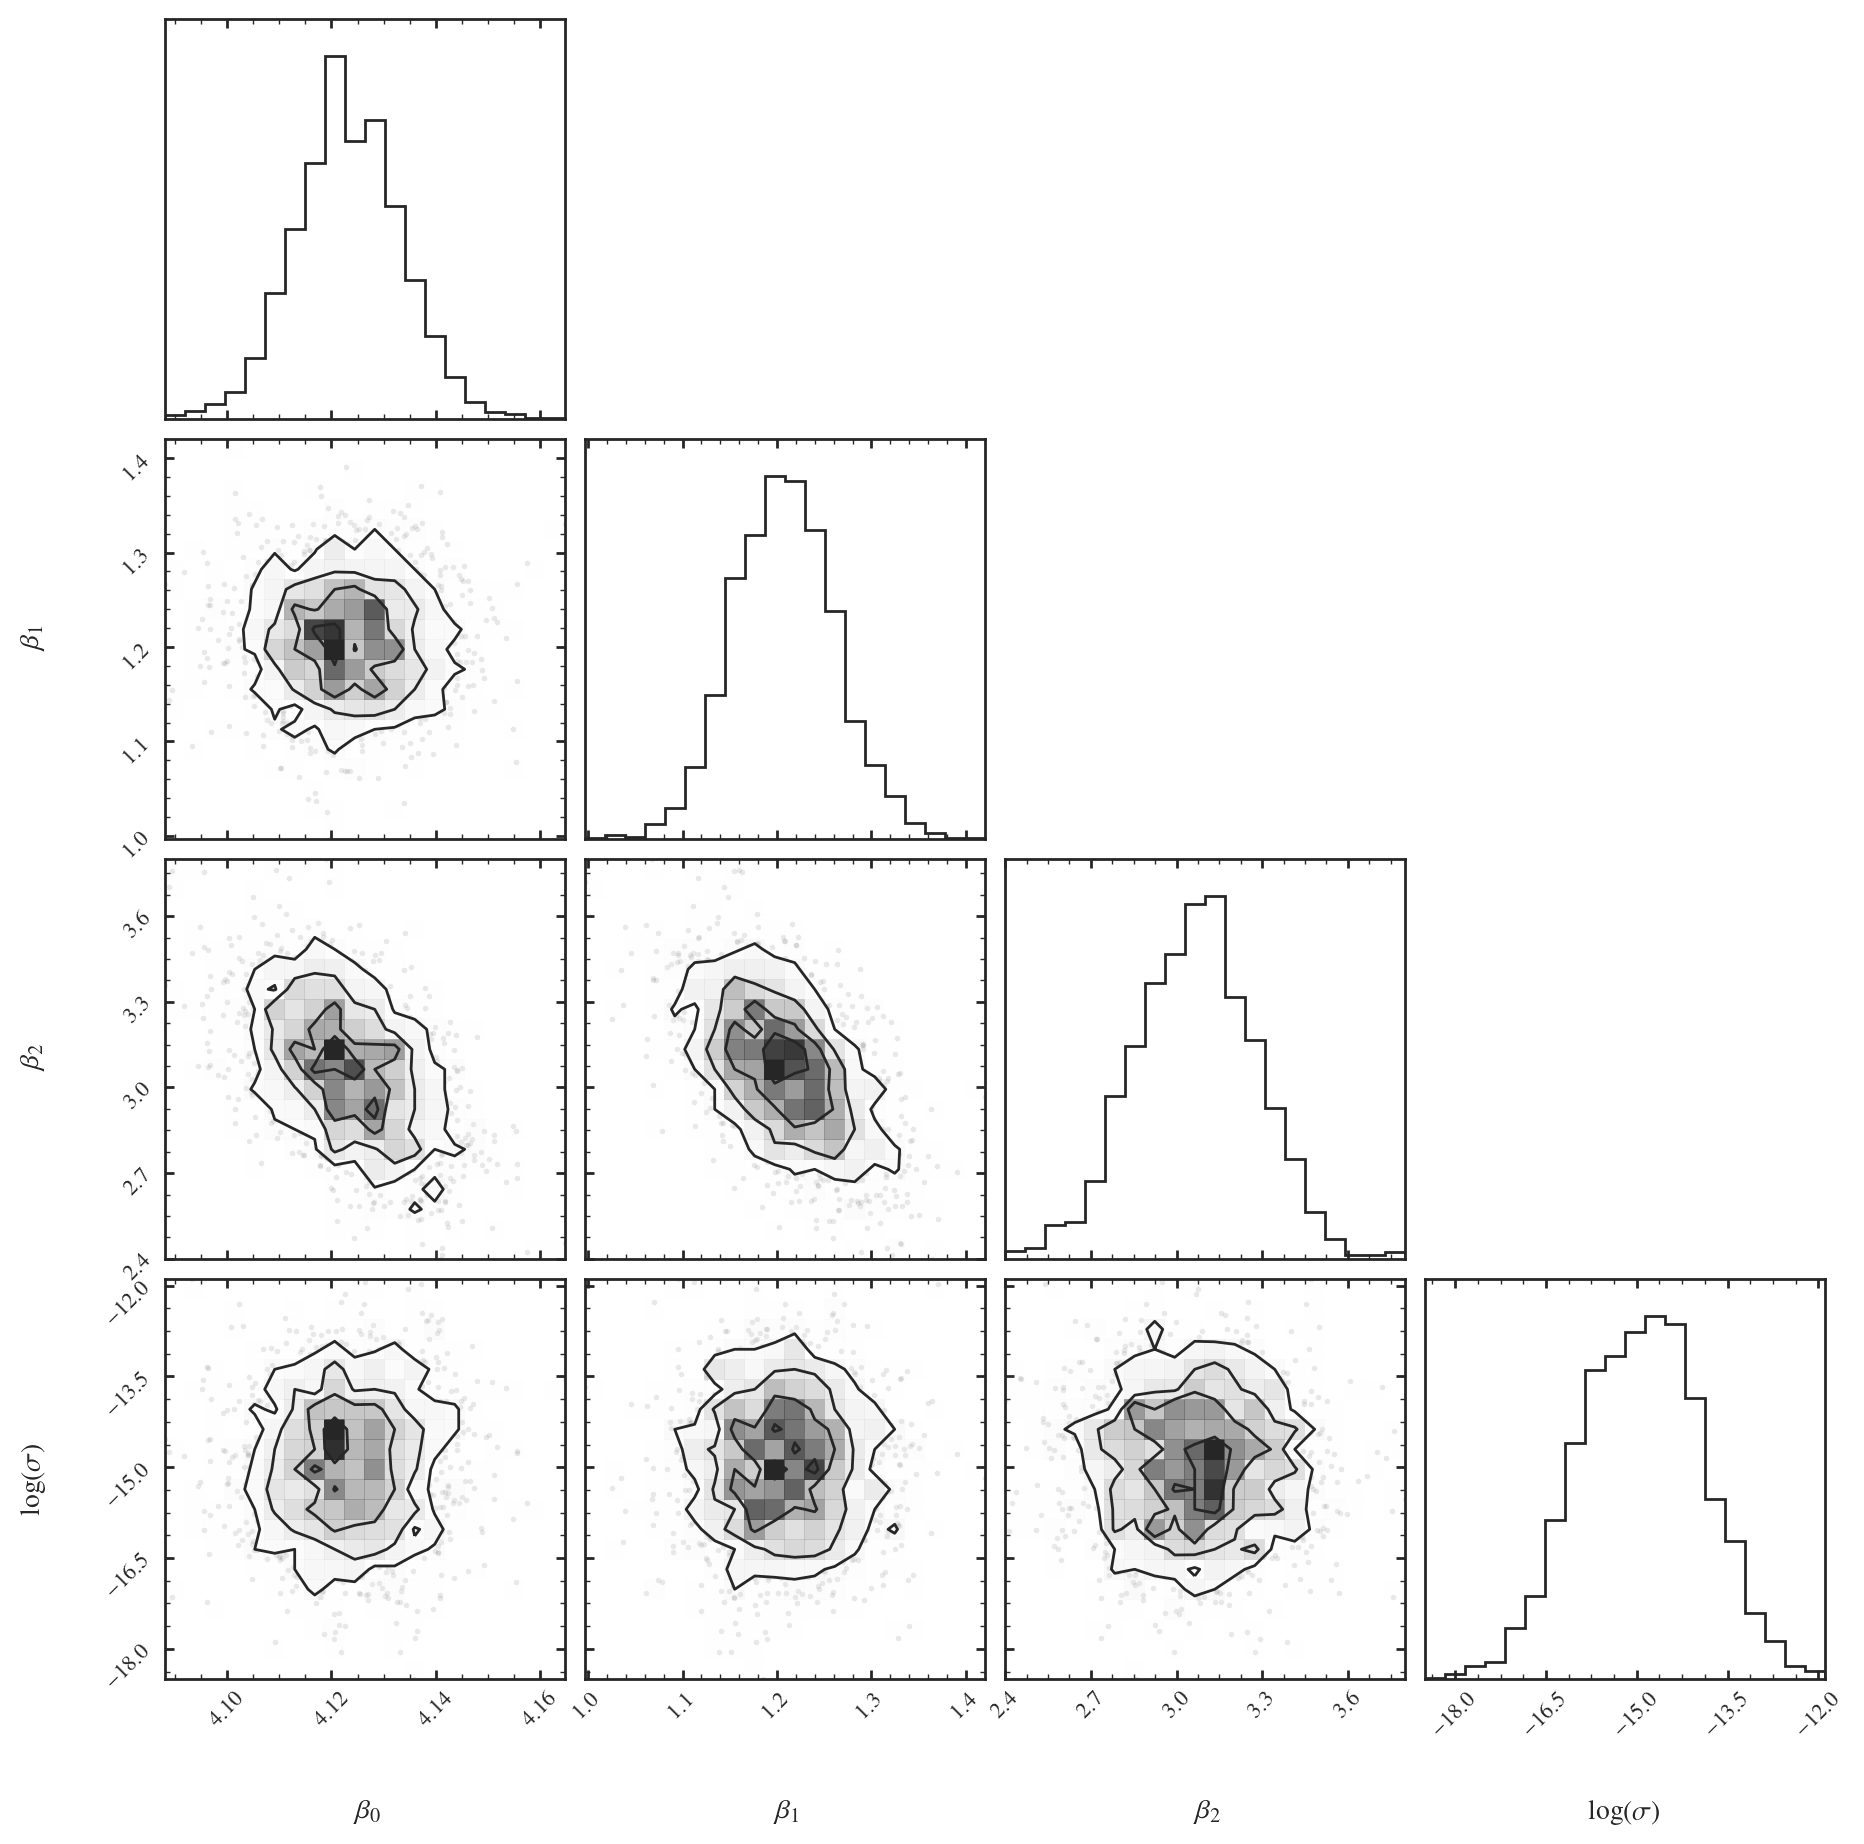

In [62]:
samples = mcmc_utils.run_mcmc(model, obs, N=N)

$\beta_0$ = 4.12e+00 + 9.48e-03 - 1.06e-02
$\beta_1$ = 1.21e+00 + 5.36e-02 - 5.26e-02
$\beta_2$ = 3.07e+00 + 2.15e-01 - 2.08e-01
$\log(\sigma)$ = -1.49e+01 + 1.06e+00 - 9.87e-01


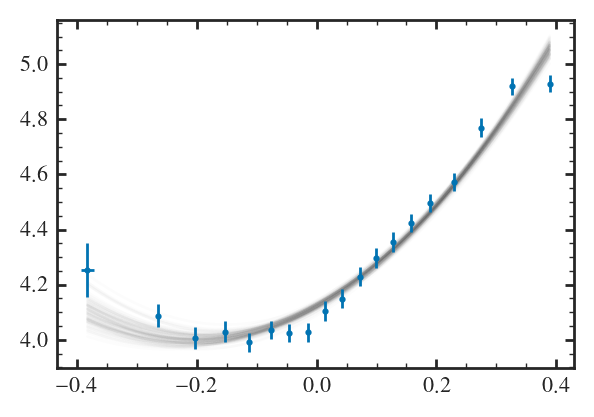

In [63]:
mcmc_utils.plot_posterior(model, obs, samples)